# Single Run Analysis

This notebook is for looking at a single simulated run.
Then we apply different analysis

In [3]:
import numpy as np
import pandas as pd
import pylab
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib.colors import ListedColormap
from turbo_colormap import *
import inspect
import os
import csv 
import time
import sys
import glob
import pandas as pd
from pprint import pprint

from tvb.simulator.lab import *
from tvb.simulator.plot.tools import *

# Input Simulation Pipeline
from SimulationPipeline import *
from useful_fns import *

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

In [4]:
TseriesFile = glob.glob("do-not-track/Old/5_8_20/LCycle_G[[]0.75[]]*Tseries*_.csv")[1]
ScorrFile = glob.glob("do-not-track/Old/5_8_20/LCycle_G[[]0.75[]]*SCorr*_.csv")[1]
FCMFile = glob.glob("do-not-track/Old/5_8_20/LCycle_G[[]0.75[]]*FCM*_.csv")[1]
print(TseriesFile)

do-not-track/Old/5_8_20\LCycle_G[0.75]_MouseCortex_Tseries_20200805-031253_.csv


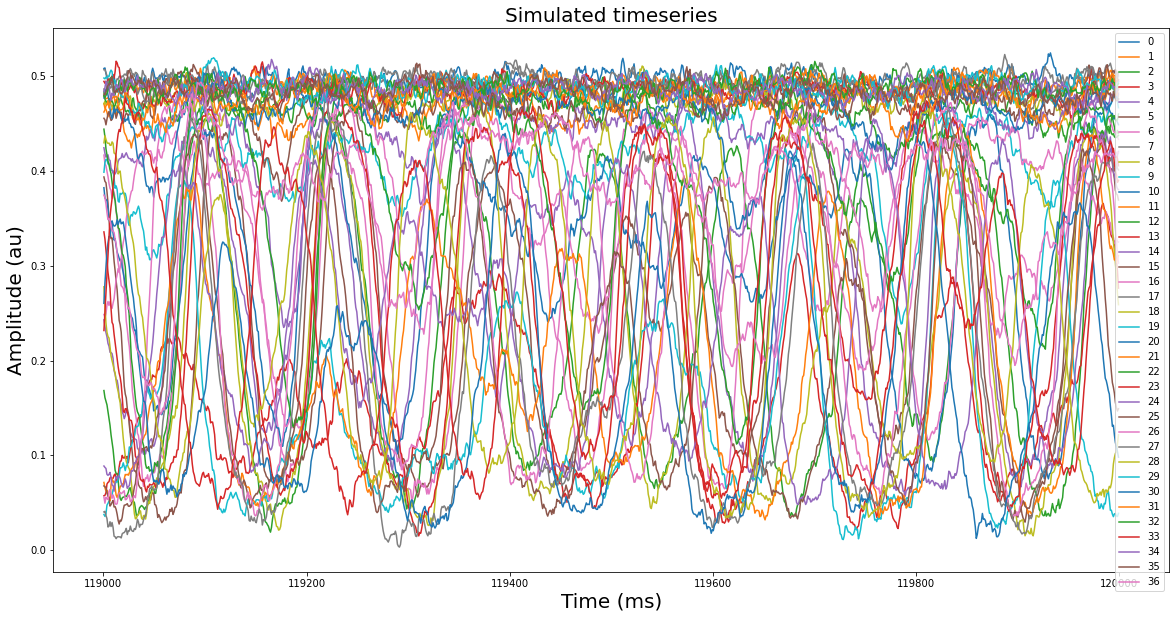

In [5]:
# Empty dict
ParamsDict = { }
ParamsDict["name"] = "MouseCortex"
#ParamsDict["G"] = np.array([1.9]) 
ParamsDict["REMOVE"] = [7]
ParamsDict["BINARY"]=True

# Read file import data
#df = pd.read_csv(all_files[11],delimiter="\t",header=None)
# Genfromtxt gives us a np array. 
df = np.genfromtxt(TseriesFile,delimiter="\t")

bold_time = df[0]
bold_data = df[1:]

# plt.subplots()

#plt.figure(num=None, figsize=(60, 30), dpi=80, facecolor='w', edgecolor='k')
# Let's only look at last 1000ms
for tseries in bold_data:
    #plt.plot(bold_time[10000:11000],tseries[10000:11000])
    plt.plot(bold_time[len(bold_time)-1000:len(bold_time)],tseries[len(bold_time)-1000:len(bold_time)])


plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated timeseries', fontsize=20)
#plt.legend(('0','1','2','3','4'))
plt.legend(range(38))
plt.show()

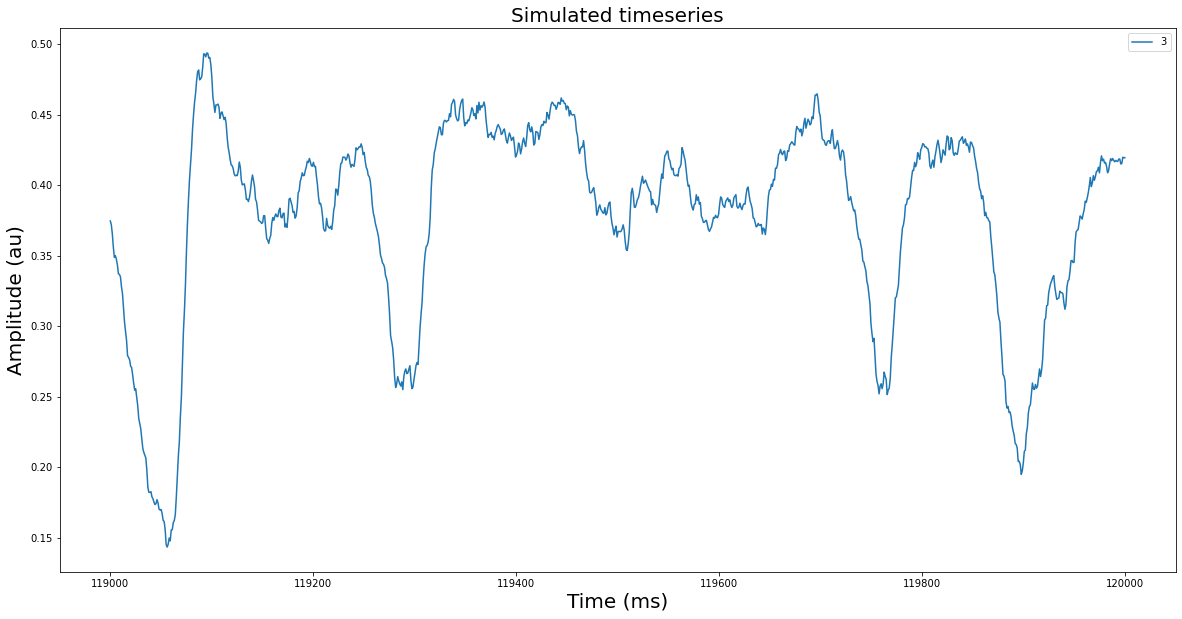

In [6]:
# Look at specific region:
Region = 36

plt.plot(bold_time[len(bold_time)-1000:len(bold_time)],bold_data[Region][len(bold_time)-1000:len(bold_time)])

plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('Amplitude (au)', fontsize=20)
plt.title('Simulated timeseries', fontsize=20)
#plt.legend(('0','1','2','3','4'))
plt.legend((str(Region)))
plt.show()

WARNING  File 'average_orientations' not found in ZIP.
WARNING  File 'cortical' not found in ZIP.
WARNING  File 'hemispheres' not found in ZIP.
WARNING  File 'areas' not found in ZIP.


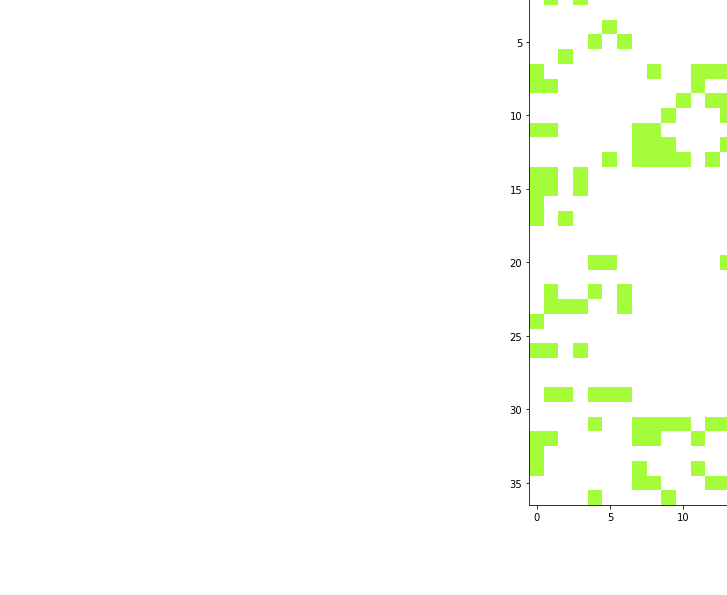

In [7]:
# Get rough feel for external currents.
# Load the connectivity data from a zip file. 
con = connectivity.Connectivity.from_file(os.getcwd() +"/Connectomes/" + ParamsDict["name"] + ".zip")

# Remove the ith row and column in centres, tract_lengths and weights. i.e. the specified region(s)
con.centres = np.delete(con.centres,ParamsDict["REMOVE"])
con.weights = np.delete(con.weights,obj=ParamsDict["REMOVE"],axis=0)
con.weights = np.delete(con.weights,obj=ParamsDict["REMOVE"],axis=1)
con.tract_lengths = np.delete(con.tract_lengths,obj=ParamsDict["REMOVE"],axis=0)
con.tract_lengths = np.delete(con.tract_lengths,obj=ParamsDict["REMOVE"],axis=1)

if ParamsDict["BINARY"]==True:
    con.weights = con.weights!=0
SCM = con.weights

# Visualize the structural connectivity matrix
plt.subplots()
cs=plt.imshow(np.log10(SCM), cmap=ListedColormap(turbo_colormap_data), aspect='equal', interpolation='none')
plt.title('Structural connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Log10(weights)', fontsize=20)
#plt.yticks([0,1,2,3])

Max 7.222981982697547
Median 2.9364690340645945
Min 0.715711306923329


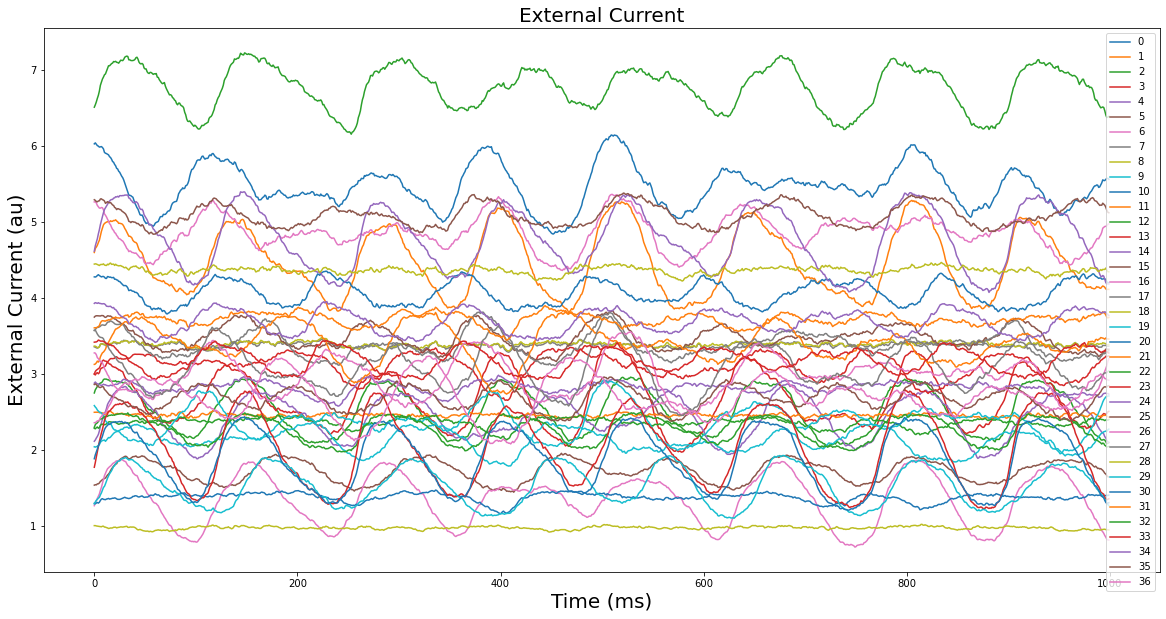

In [8]:
# External Current Calculator:
J_e = []
#len(bold_time)
for j in np.arange(1000):       
    t_0 = []
    # Specific column (or time point)
    for i in np.arange(SCM.shape[0]): 
        # Sum over all external currents (May need to do SCM[:,i] instead)  
        t  = sum(bold_data[:,j]*SCM[:,i])
        # To obtain currents to particular region
        t_0.append(t)
    J_e.append(t_0)

J_e = np.array(J_e)
print("Max",np.max(J_e))
print("Median",np.median(J_e))
print("Min",np.min(J_e))

plt.plot(J_e)
plt.xlabel('Time (ms)', fontsize=20)
plt.ylabel('External Current (au)', fontsize=20)
plt.title('External Current', fontsize=20)
#plt.legend(('0','1','2','3','4'))
plt.legend(range(38))
plt.show()

Text(0.5, 1.0, 'Mean External Current per Region')

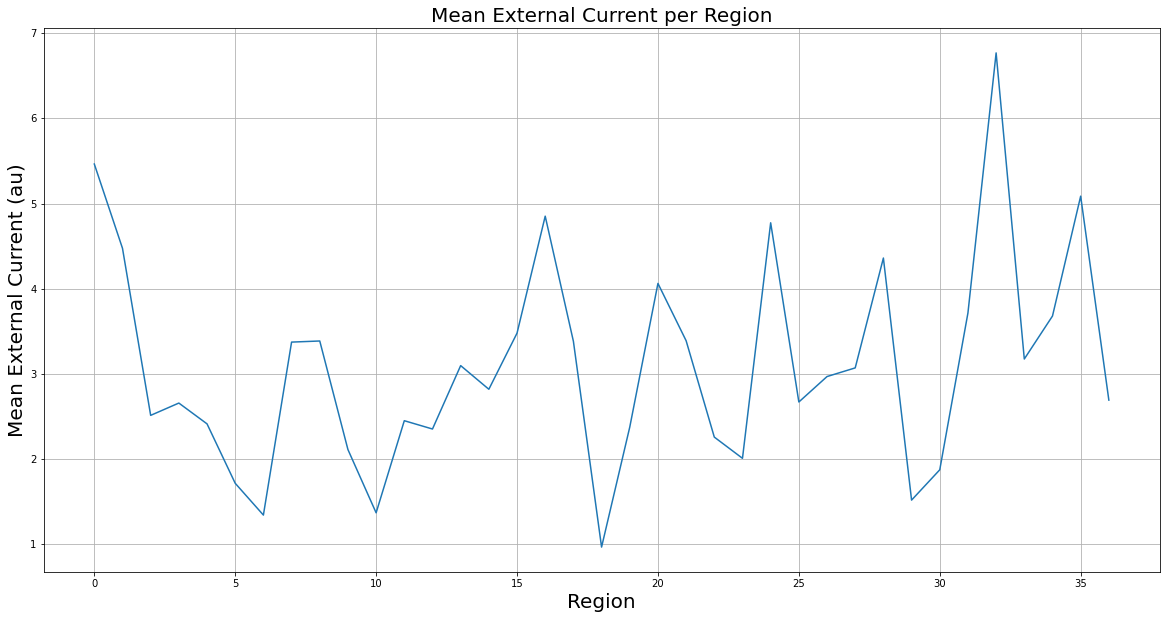

In [9]:
df = pd.DataFrame(J_e)
plt.plot(df.sum(axis=0)/1000)
plt.grid()
plt.xlabel('Region', fontsize=20)
plt.ylabel('Mean External Current (au)', fontsize=20)
plt.title('Mean External Current per Region', fontsize=20)

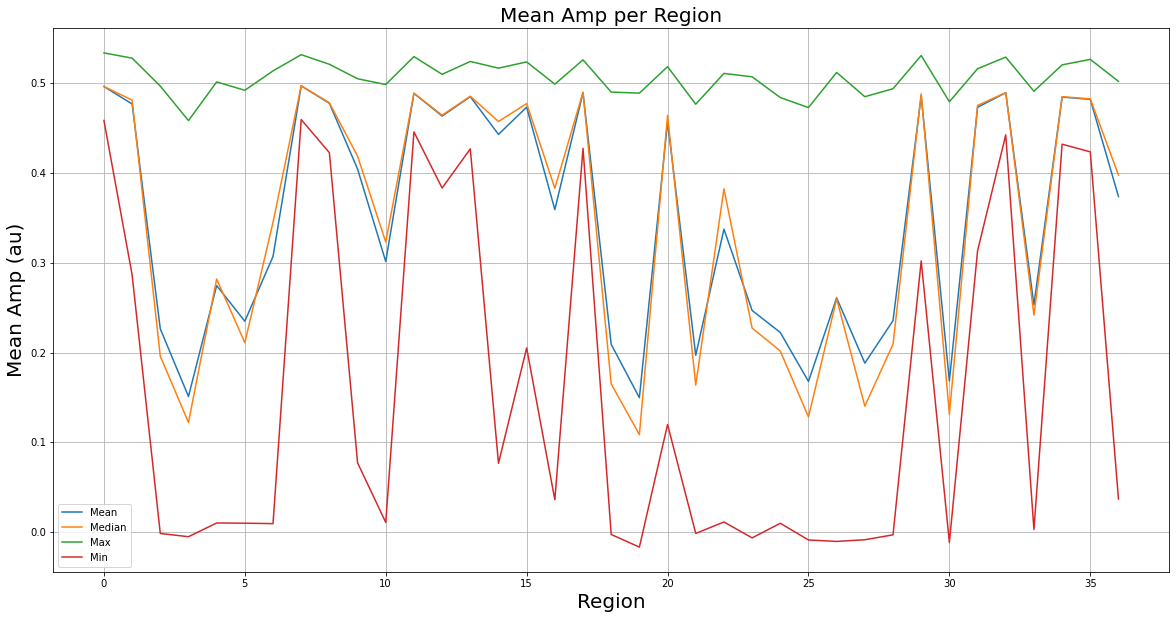

In [10]:
# Mean Amplitude Calculator.

X = list(map(np.mean,bold_data))
XX = list(map(np.median,bold_data))
Y = list(map(np.max,bold_data))
Z = list(map(np.min,bold_data))
plt.plot(X)
plt.plot(XX)
plt.plot(Y)
plt.plot(Z)
plt.grid()
plt.xlabel('Region', fontsize=20)
plt.ylabel('Mean Amp (au)', fontsize=20)
plt.title('Mean Amp per Region', fontsize=20)
plt.legend(("Mean","Median","Max","Min"))

[3.89997024e-01 1.25038967e-49 6.12983063e-01 5.77582049e-70]


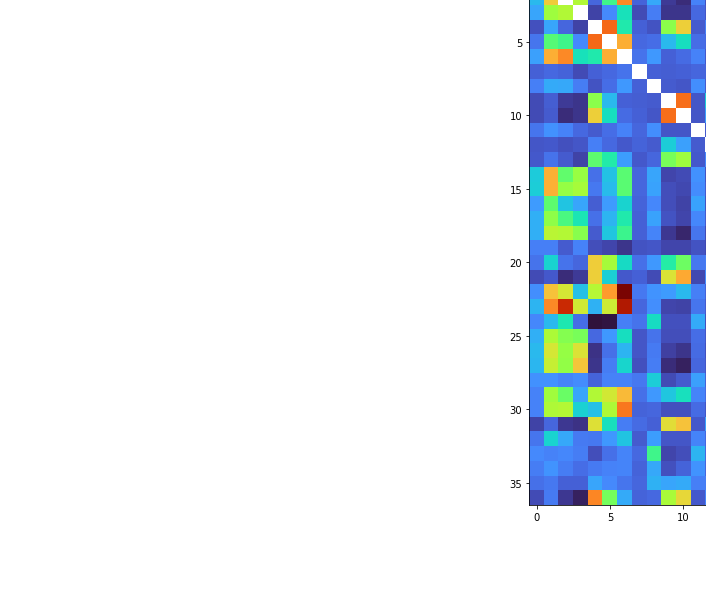

In [11]:
Scorra = np.genfromtxt(ScorrFile)
print(Scorra)

# Plot Simulated FCM
FCM_sim = np.genfromtxt(FCMFile,delimiter="\t")

# ListedColormap(turbo_colormap_data)
cs=plt.imshow(FCM_sim, cmap=ListedColormap(turbo_colormap_data), aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])
plt.show()

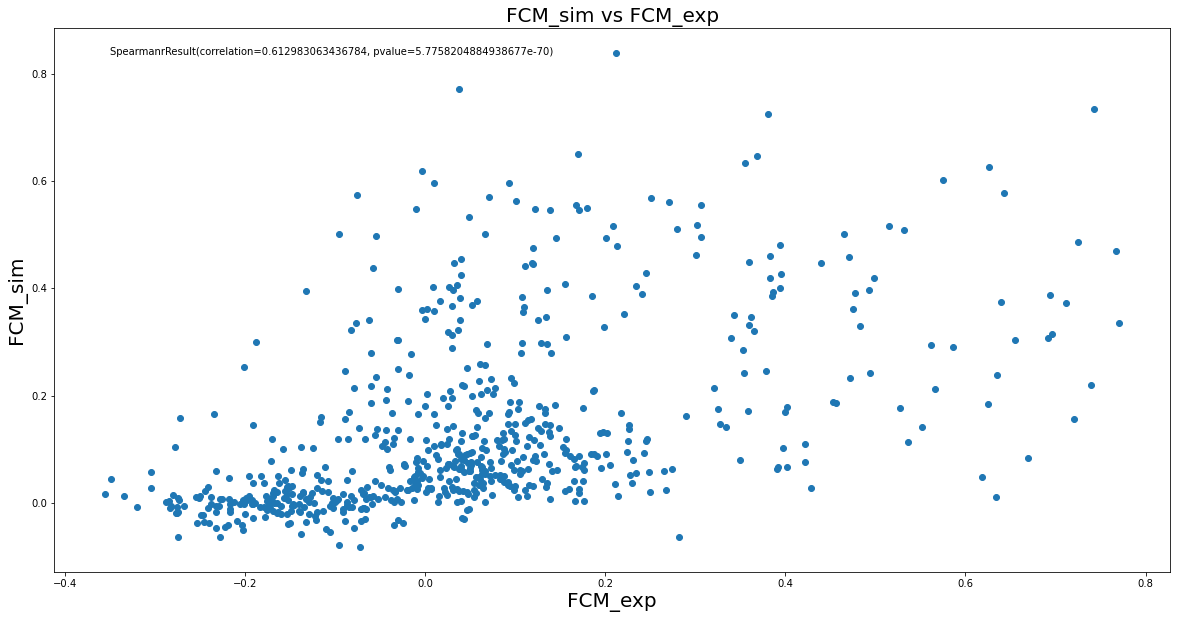

In [12]:
FCM_exp = np.genfromtxt('FCM_MouseExperimental.csv',delimiter = "\t")
# Set diagonals to NaN
np.fill_diagonal(FCM_exp,np.nan)

# Remove the ith row and column in FCM (i.e. the specified region)
FCM_exp = np.delete(FCM_exp,obj=ParamsDict["REMOVE"],axis=0)
FCM_exp = np.delete(FCM_exp,obj=ParamsDict["REMOVE"],axis=1)

FCM_Exp_U = FCM_exp[np.triu_indices(FCM_exp.shape[0], k = 1)]
FCM_Sim_U = FCM_sim[np.triu_indices(FCM_sim.shape[0], k = 1)]

# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Exp_U,b=FCM_Sim_U)
#print(SCorr)

# Scatterplot
plt.scatter(FCM_Exp_U,FCM_Sim_U)
plt.xlabel('FCM_exp', fontsize=20)
plt.ylabel('FCM_sim', fontsize=20)
plt.title('FCM_sim vs FCM_exp', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()

## Sort by attractor dynamics (which is mean amplitude)

In [13]:
# Obtain indexes of regions in order of ascending mean amplitude:
index = np.argsort(X)

# Rearrange FCM_sim accordingly:
# https://stackoverflow.com/questions/10936767/rearranging-matrix-elements-with-numpy
A1 = FCM_sim[:, index][index]
#print(A1)
# Re-order FCM_exp as well: 
A2 = FCM_exp[:, index][index]
#print(A2)

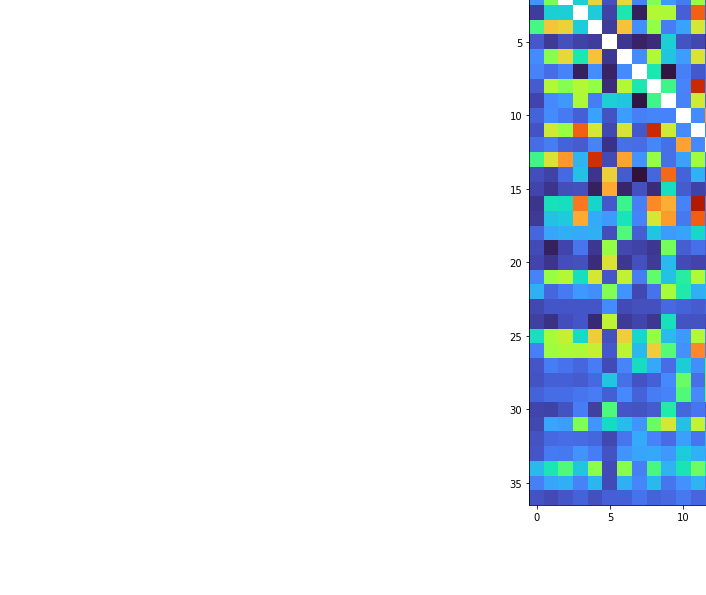

In [14]:
# ListedColormap(turbo_colormap_data)
cs=plt.imshow(A1, cmap=ListedColormap(turbo_colormap_data), aspect='equal', interpolation='none')
plt.title('Functional connectivity matrix - Reordered by Amp', fontsize=20)
axcb=plt.colorbar(cs)
axcb.set_label('Correlation', fontsize=20)
#plt.yticks([0,1,2,3])
plt.show()

In [15]:
# Now Need to select the regions we actually want to keep:
start_index = 0
end_index = 17
# FCM_sim
B1 = A1[start_index:end_index, start_index:end_index]
# FCM_exp
B2 = A2[start_index:end_index, start_index:end_index]

# For High Amplitude
start_index = end_index + start_index 
end_index = FCM_exp.shape[0]
# FCM_sim
C1 = A1[start_index:end_index, start_index:end_index]
# FCM_exp
C2 = A2[start_index:end_index, start_index:end_index]

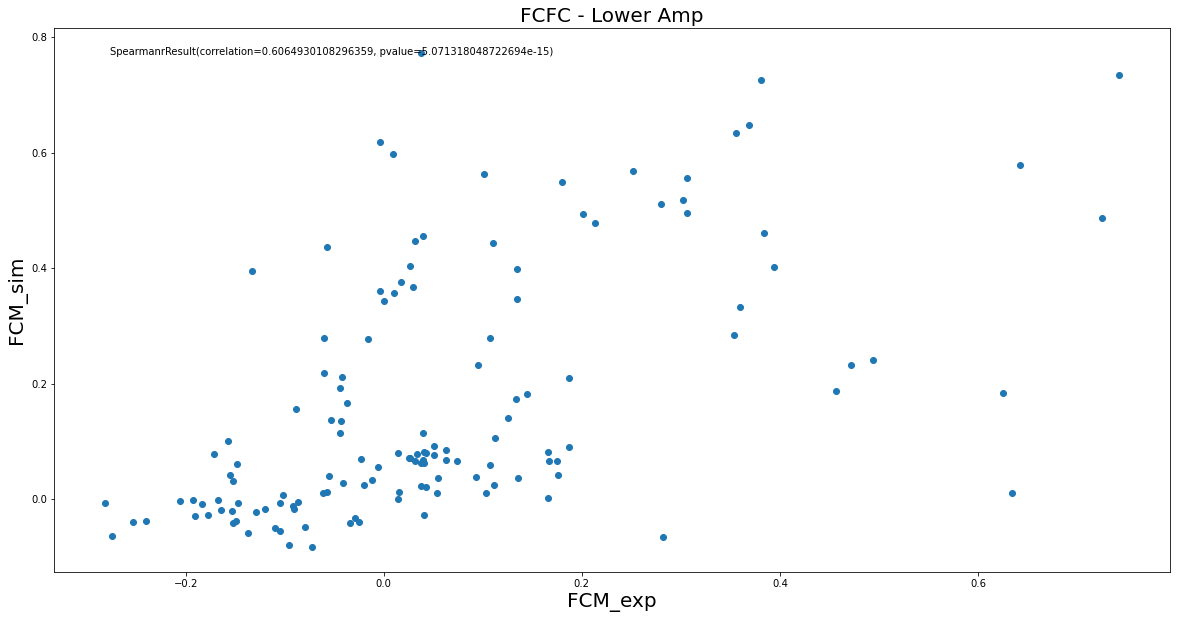

In [16]:
FCM_Exp_U = B2[np.triu_indices(B2.shape[0], k = 1)]
FCM_Sim_U = B1[np.triu_indices(B1.shape[0], k = 1)]

# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Exp_U,b=FCM_Sim_U)
#print(SCorr)

# Scatterplot
plt.scatter(FCM_Exp_U,FCM_Sim_U)
plt.xlabel('FCM_exp', fontsize=20)
plt.ylabel('FCM_sim', fontsize=20)
plt.title('FCFC - Lower Amp', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()

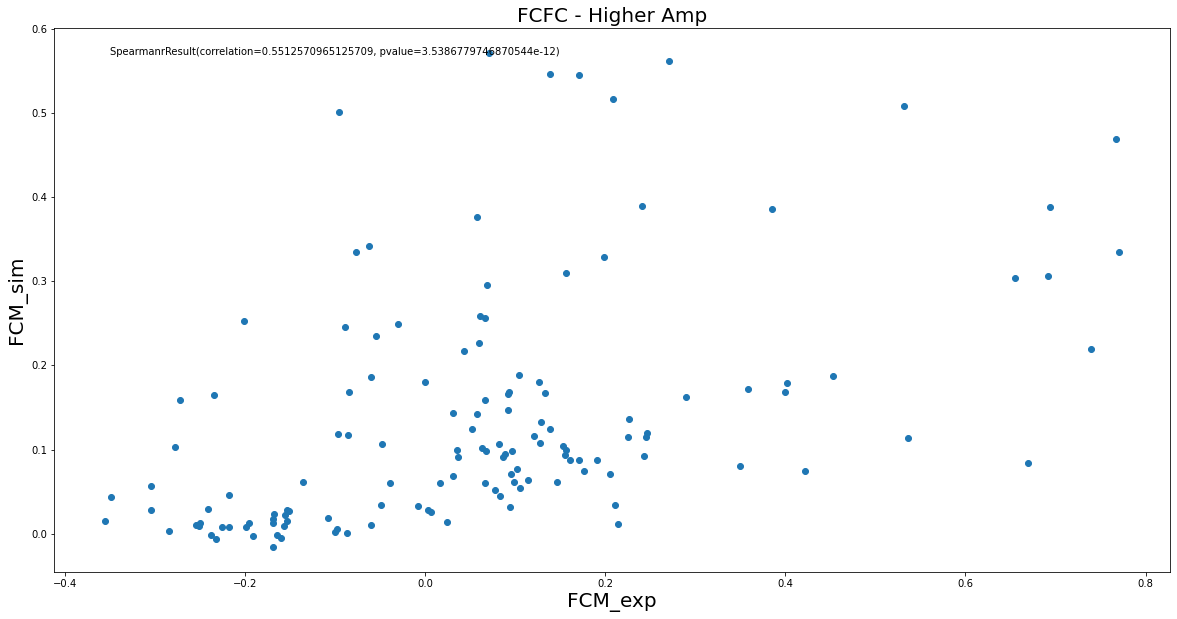

In [17]:
FCM_Exp_U = C2[np.triu_indices(B2.shape[0], k = 1)]
FCM_Sim_U = C1[np.triu_indices(B1.shape[0], k = 1)]

# Spearman Correlation
SCorr = stats.spearmanr(a=FCM_Exp_U,b=FCM_Sim_U)
#print(SCorr)

# Scatterplot
plt.scatter(FCM_Exp_U,FCM_Sim_U)
plt.xlabel('FCM_exp', fontsize=20)
plt.ylabel('FCM_sim', fontsize=20)
plt.title('FCFC - Higher Amp', fontsize=20)
plt.annotate(SCorr, xy=(0.05, 0.95), xycoords='axes fraction')
plt.show()